# Introduction
In the modern Internet age, textual data is ever increasing. Need some way to condense this data
while preserving the information and meaning.We need to summarize textual data for that. Text
summarization is the process of automatically generating natural language summaries from an input
document while retaining the important points. It would help in easy and fast retrieval of information.

There are two prominent types of summarization algorithms.

• Extractive summarization systems form summaries by copying parts of the source text
through some measure of importance and then combine those part/sentences together to
render a summary. Importance of sentence is based on linguistic and statistical features.

• Abstractive summarization systems generate new phrases, possibly rephrasing or using
words that were not in the original text. Naturally abstractive approaches are harder. For
perfect abstractive summary, the model has to first truly understand the document and then
try to express that understanding in short possibly using new words and phrases. Much
harder than extractive. Has complex capabilities like generalization, paraphrasing and incorporating real-world knowledge.

Majority of the work has traditionally focussed on extractive approaches due to the easy of defining
hard-coded rules to select important sentences than generate new ones. Also, it promises grammatically correct and coherent summary. But they often don’t summarize long and complex texts well
as they are very restrictive.

With models like BERT (https://arxiv.org/abs/1810.04805) and Tranformers (https://arxiv.org/abs/1706.03762) the quality of language generation models has improved many folds, which will be explored in the next notebook. But it's essential to understand the drawbacks of seq2seq model as a baseline to be able to appreciate the ideas of improvements in the later models and and thus I have tried it below! :)

# Model architecture 
1. Glove embedding 
2. seq2seq encoder decoder architecture with LSTM layer.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn.feature_extraction import stop_words
import re
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys, tarfile

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from IPython.display import Image

from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer,text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Dense, Activation, concatenate,LSTM, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import optimizers
# Any results you write to the current directory are saved as output.

['glove-global-vectors-for-word-representation', 'kindle-reviews']


Using TensorFlow backend.


For this problem, we are using kindle reviews dataset from kaggle. There are many other features of this dataset which might not be relevant to the problem at hand. The reviewText and summary are used here. The dataset contains approximately million datapoints for us to train model on

In [2]:
kindle_reviews = pd.read_csv('../input/kindle-reviews/kindle_reviews.csv')

In [3]:
kindle_reviews.shape

(982619, 10)

In [4]:
kindle_reviews.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [5]:
# Reformatting the dataframe 

pd.set_option('display.max_info_columns',1000)
pd.set_option('display.max_colwidth',5000)
kindle_reviews.drop(columns = ['asin', 'helpful', 'overall', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'],
                    axis=1, inplace=True)
kindle_reviews.columns = ['index','review', 'summary']
kindle_reviews.set_index(keys = 'index',inplace=True)

# Text preprocessing :
1. lowercasing
2. stop words removal : a new dictionary of stop words is created to preserve the meaning of the original text
3. contractions 
4. punctuations removal
5. Unnecessary white space 


In [6]:

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


def clean_text(text,remove_stopwords = True):
    '''
    Given a text this function removes the punctuations, selected stopwords(because not, none convey some meaning and
    removing these stop words changes the meaning of the sentence.) and returns the length of the remaining text string
    '''
    refined_stop_words = {}
    if(remove_stopwords == True):
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS-{ "not","none","nothing","nowhere","never",
                                                        "cannot","cant","couldnt","except","hasnt",
                                                        "neither","no","nobody","nor","without"
                                                           }
    try:
        #convert to lower case and strip regex
        new_text = ""
        text = text.lower()
        for word in text.split():
            if word in refined_stop_words:
                continue
            if word in contractions:
                new_text = new_text + " " + (contractions[word])
            else: 
                new_text = new_text + " " + word
        text = new_text
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(" ", text)
        text = re.sub('\s+', ' ', text).strip()
        return text
    except:
        return ""

In [7]:
kindle_reviews['summary'] = kindle_reviews.summary.apply(lambda x: clean_text(x))
kindle_reviews['review'] = kindle_reviews.review.apply(lambda x: clean_text(x))

Length of the reviews and summary is essential to consider while deciding hyperparameters such as sequence length

In [8]:
kindle_reviews['summary_length'] = kindle_reviews.summary.apply(lambda x: len(x.split()))
kindle_reviews['review_length'] = kindle_reviews.review.apply(lambda x: len(x.split()))

In [9]:
kindle_reviews.review_length.describe(percentiles = [0.25, 0.9, 0.95, 0.99])

count    982619.000000
mean         56.930118
std          69.306447
min           0.000000
25%          17.000000
50%          31.000000
90%         136.000000
95%         194.000000
99%         335.000000
max        2291.000000
Name: review_length, dtype: float64

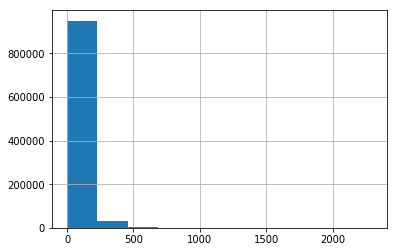

In [10]:
kindle_reviews.review_length.hist()

In [11]:
kindle_reviews.summary_length.describe(percentiles = [0.9,0.95,0.99])

count    982619.000000
mean          2.784196
std           1.725640
min           0.000000
50%           2.000000
90%           5.000000
95%           6.000000
99%           9.000000
max          37.000000
Name: summary_length, dtype: float64

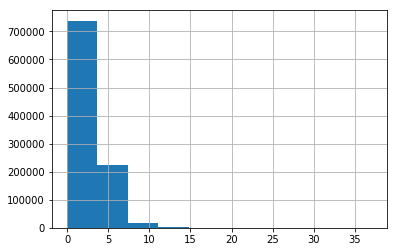

In [12]:
kindle_reviews.summary_length.hist()

# Input output to the model

In [13]:
# All the model hyperparameters are defined here, considering 99th percentile review and summary lengths

RNN_VOCAB = 15000                           # most frequent 15K words form the vocab 
MAX_SEQUENCE_REVIEW_LENGTH = 20             
MAX_SEQUENCE_SUMMARY_LENGTH = 9
EMBEDDING_DIM = 200                         
EMBEDDING_FILE_PATH = "../input/glove-global-vectors-for-word-representation/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
LATENT_DIM = 256                   # Dimensions of LSTM output
tokens = ['EOS', 'BOS']            # 'EOS': END OF THE SENTENCE AND 'BOS': BEGINNING OF THE SENTENCE added to the vocab

The below code is commented, but if required due to computational constraints, the dataset size could be reduced by not considering very short or long summaries and reviews 

In [14]:
kindle_reviews = kindle_reviews.loc[(kindle_reviews.review_length<=MAX_SEQUENCE_REVIEW_LENGTH) & (kindle_reviews.review_length>=10) & (kindle_reviews.summary_length>=2) & (kindle_reviews.summary_length<=MAX_SEQUENCE_SUMMARY_LENGTH-2) ]

Dataset is fairly large for the available processing time. Thus we will be training in batches. 

Let's tokenize this data using keras tokenizer API 

In [15]:
tokenize = Tokenizer(num_words = RNN_VOCAB, oov_token='OOV')
tokenize.fit_on_texts(np.hstack([kindle_reviews['summary'],kindle_reviews['review']]))
kindle_reviews['sequence_summary'] = tokenize.texts_to_sequences(kindle_reviews['summary'])
kindle_reviews['sequence_review'] = tokenize.texts_to_sequences(kindle_reviews['review'])

In [16]:
print("Total number of unique words = ", len(tokenize.word_index))

Total number of unique words =  58930


Although there are 291K unique words in the dataset, due to constraints we are using, the most frequent 15K words to form our vocab. In short, 276K tokens would be treated as unknown words and hence, many times our model will tend to be biased to generate UNK token just cause of it's sheer frequency in the dataset, considering it to be more probable.

One way is to remove the samples having OOV token, which is implemented below

In [17]:
reviews = kindle_reviews.loc[kindle_reviews['sequence_summary'].apply(lambda x: not(1 in x))]

In [18]:
reviews.shape

(196133, 6)

In [19]:
reviews = kindle_reviews.loc[kindle_reviews['sequence_review'].apply(lambda x: not(1 in x))]

In [20]:
reviews.shape

(159117, 6)

In [21]:
kindle_reviews = reviews

In [22]:

#INDEX_T = RNN_VOCAB+2
#DATASET_SIZE = 40000
BATCH_SIZE = 1024
NUM_EPOCHS = 3
STEPS_PER_EPOCH = 150
VAL_DATASET_SIZE = int(kindle_reviews.shape[0]*0.05)    # make sure validation data size is bigger than batch size

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(kindle_reviews.review, kindle_reviews.summary, test_size = 0.01)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((157525,), (1592,), (157525,), (1592,))

The decoder input, should have a start and end token, and thus we add it to our vocab

In [24]:
tokenize.word_index['EOS'] = RNN_VOCAB+1   #End of the sentence token
tokenize.word_index['SOS'] = RNN_VOCAB  #Start of the sentence token

Every decoder input - summary is augmented with 'EOS' and preceeded by 'SOS' 

In [25]:
kindle_reviews['sequence_summary'] += [tokenize.word_index['EOS']]

#Decoder input is one timestep ahead of decoder oupput 
kindle_reviews['sequence_summary_decoder_input'] = [tokenize.word_index['SOS']] + kindle_reviews['sequence_summary']

In [26]:
#craeting dataset for the model input output
dataset = {}
dataset['decoder_input'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH, padding='post')
dataset['decoder_output'] = pad_sequences(kindle_reviews.sequence_summary_decoder_input, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH-1, padding='post')
dataset['encoder_input'] = pad_sequences(kindle_reviews.sequence_review, maxlen = MAX_SEQUENCE_REVIEW_LENGTH, padding='pre')

In [27]:
dataset['decoder_output'].shape

(159117, 8)

In [28]:
dataset['encoder_input'][0:2]

array([[   0,    0,    0,    0,    0,    0,    0,   17,  899, 1593, 6376,
        9212,   44,   86,   20,  400,   66,   99,   38,  492],
       [   0,    0,    0,    0,    0,   25,    7,    2,  321, 1600, 1780,
          25,   20,  336,  492,    5,    2,   14,   56,   31]],
      dtype=int32)

Just to give you an idea of the complexity of this problem, consider the following:
our model outputs probability of each word in the vocab (15K) probabilities, for each timestep.
The number of timesteps for decoder are 9. and we have 423K datapoints. To store the decoder output at training step, we would require (423K \* 9 \* 15K) float value memory,Thus it's inefficient to be training the model, on the entire dataset. 

In such cases fit_generate method of keras comes handy. We can create batches of the input and output as the model trains and the previous batch is discarded at every step of the epoch! It's implemented below

In [29]:
def get_batch_data(dataset, start, end):
    # Decoder output will be one hot encoded values 
    # dimensions of the decoder output will be (number of samples * summary length * vocab size)
    assert start < end
    #assert end <= dataset['encoder_input'].shape[0]
    encoder_batch_input = dataset['encoder_input'][start:end]
    decoder_batch_input = dataset['decoder_input'][start:end]
    decoder_batch_output = np.zeros(((end-start), MAX_SEQUENCE_SUMMARY_LENGTH, RNN_VOCAB+3), dtype = 'float16')
    for k, row in enumerate(dataset['decoder_output'][start:end]):
        for i,value in enumerate(row):
            if value!=0:
                decoder_batch_output[k, i, value] = 1
    return encoder_batch_input, decoder_batch_input, decoder_batch_output

In [30]:
#This generate method loops indefinitely on our dataset to create training batches
def generate_batch_data(dataset):
    size = dataset['encoder_input'].shape[0]
    while True:
        start = 0
        end = start+BATCH_SIZE
        while True:
            # create numpy arrays of input data
            # and labels, from each line in the file
            if start>=size:
                break
            encoder_batch_input, encoder_batch_output, decoder_batch_output = get_batch_data(dataset, start, end)
            start = end
            end = np.min([end+BATCH_SIZE, size])
            yield ({'review': encoder_batch_input, 
                    'summary': encoder_batch_output},
                   {'decoder_dense_layer': decoder_batch_output})


In [31]:
dataset_val = {}
dataset_val['encoder_input'] = dataset['encoder_input'][0:VAL_DATASET_SIZE]
dataset_val['decoder_input'] = dataset['decoder_input'][0:VAL_DATASET_SIZE]
dataset_val['decoder_output'] = dataset['decoder_output'][0:VAL_DATASET_SIZE]

dataset['encoder_input'] = dataset['encoder_input'][VAL_DATASET_SIZE:]
dataset['decoder_input'] = dataset['decoder_input'][VAL_DATASET_SIZE:]
dataset['decoder_output'] = dataset['decoder_output'][VAL_DATASET_SIZE:]

In [32]:
dataset_val['encoder_input'].shape, dataset_val['decoder_input'].shape, dataset_val['decoder_output'].shape

((7955, 20), (7955, 9), (7955, 8))

In [33]:
dataset['encoder_input'].shape, dataset['decoder_input'].shape, dataset['decoder_output'].shape

((151162, 20), (151162, 9), (151162, 8))

# Embeddings

In [34]:
class Embeddings:
    """
    When a corpus is passed, remove the words which are not in the global vocab(glove) and use most frequent vocab_size
    number of words. 
    """
    def __init__(self, embedding_dim, vocab_size):
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
    def readEmbeddings(self, filePath):
        """
        Given a filepath of word embeddings creates and returns a dictionary of word, embedding values
        """
        # Create a dictionary for storing all {word, embedding values}
        wordToEmbeddingDict = {}
        # open the file as read only
        file = open(filePath, encoding='utf-8')
        # read all text
        for line in file:
            lineValue = line.split()
            word = lineValue[0]
            embedding = np.asarray(lineValue[1:],dtype = 'float32')
            wordToEmbeddingDict[word] = embedding
        # close the file
        file.close()
        return wordToEmbeddingDict
    
    def indexToEmbedding(self, wordToIndexDict, wordToEmbeddingDict):
        indexToEmbeddingMatrix = np.zeros((self.vocab_size+3, self.embedding_dim))
        for word, index in wordToIndexDict.items():
            if index > self.vocab_size+2:
                break
            if word in wordToEmbeddingDict.keys():
                indexToEmbeddingMatrix[index] = wordToEmbeddingDict[word]
            else:
                indexToEmbeddingMatrix[index] = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))
        return indexToEmbeddingMatrix
    
    def indexToWord(self, wordToIndexDict):
        return {index: word for word, index in wordToIndexDict.items()}

In [35]:
embeddings = Embeddings(EMBEDDING_DIM, RNN_VOCAB)
wordToEmbeddingDict = embeddings.readEmbeddings(EMBEDDING_FILE_PATH)

indexToEmbeddingMatrix = embeddings.indexToEmbedding(tokenize.word_index, wordToEmbeddingDict)

In [36]:
indexToWordDict = embeddings.indexToWord(tokenize.word_index)

In [37]:
indexToEmbeddingMatrix.shape

(15003, 200)

# Define the model
## 1. Training model

In [38]:
review_input_layer = Input(shape=(MAX_SEQUENCE_REVIEW_LENGTH, ), name = 'review')
embedding_encoder_layer = Embedding(input_length = MAX_SEQUENCE_REVIEW_LENGTH,
                          input_dim = RNN_VOCAB+3,
                          output_dim = EMBEDDING_DIM,
                          weights=[indexToEmbeddingMatrix],
                          trainable = False,
                          name = 'embedding_encoder',
                          mask_zero = True)
embedding_review_output = embedding_encoder_layer(review_input_layer)
encoder_lstm_layer = LSTM(LATENT_DIM, return_state=True, name = 'lstm_encoder')
_, state_h, state_c = encoder_lstm_layer(embedding_review_output)
encoder_states = [state_h, state_c]


summary_input_layer = Input(shape=(MAX_SEQUENCE_SUMMARY_LENGTH, ), name = 'summary')
embedding_decoder_layer = Embedding(#input_length = MAX_SEQUENCE_SUMMARY_LENGTH,
                          input_dim = RNN_VOCAB+3,
                          output_dim = EMBEDDING_DIM,
                          weights=[indexToEmbeddingMatrix],
                          trainable=False,
                          name = 'embedding_decoder',
                          mask_zero = True)
embedding_summary_output = embedding_decoder_layer(summary_input_layer)
decoder_lstm_layer = LSTM(LATENT_DIM, return_state=True, return_sequences = True, name = 'lstm_decoder')
decoder_softmax_output, decoder_h, decoder_c = decoder_lstm_layer(embedding_summary_output,
                                                   initial_state = encoder_states)


decoder_dense_layer = Dense(RNN_VOCAB+3, activation="softmax", name='decoder_dense_layer')
decoder_dense_output =  decoder_dense_layer(decoder_softmax_output)


model = Model([review_input_layer, summary_input_layer], decoder_dense_output) 
sgd = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
plot_model(model, to_file='model.png', show_shapes=True)

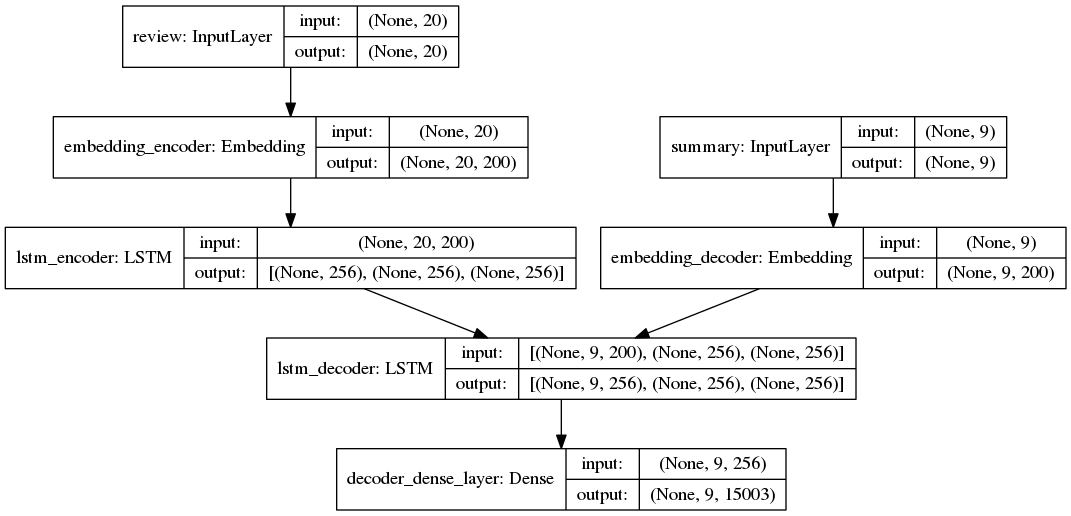

In [40]:
Image(filename='model.png') 

In [41]:
model.fit_generator(generator = generate_batch_data(dataset),use_multiprocessing=True,
                    validation_data = generate_batch_data(dataset_val),
                    validation_steps = dataset_val['encoder_input'].shape[0]//BATCH_SIZE,
                    epochs=NUM_EPOCHS, steps_per_epoch = dataset['encoder_input'].shape[0]//BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/3
147/147 [==============================] - 355s 2s/step - loss: 4.2827 - val_loss: 3.3387
Epoch 2/3
147/147 [==============================] - 332s 2s/step - loss: 2.6407 - val_loss: 2.2361
Epoch 3/3
147/147 [==============================] - 331s 2s/step - loss: 1.8043 - val_loss: 1.6349


In [42]:
#Always save your weights
model.save_weights('summarization_weights.h5')

In [43]:
model.load_weights('summarization_weights.h5')

In the inference model, we need to keep in mind following few things

First we will encode the sequence, the encoder's output is of no use thus it will be discarded, state_c and state_h will be used as initial state of decoder, same as training. 

Also decoder will receive one input of initial time step ('bos' token to get started)

Decoder inputs : [encoder states , 'bos']

1) decoder RNN will output one word at a time,(output dim :{ 1, 1, RNN_VOCAB}

2) from argmax index to word mapping could be used to find the output word,

For the next timestep we need the decoder's states as well as an output of decoder LSTM

3) Next we need to provide our decoder with the decoder states and the output word again

We need to encapsulate decoder in separate block, is because it is gonna run recursively


## 2. Inference model
Like training we have 2 separate models for encoder and decoder. 
### 2.1 Encoder
From encoder we extract the thought vector to feed to the decoder.

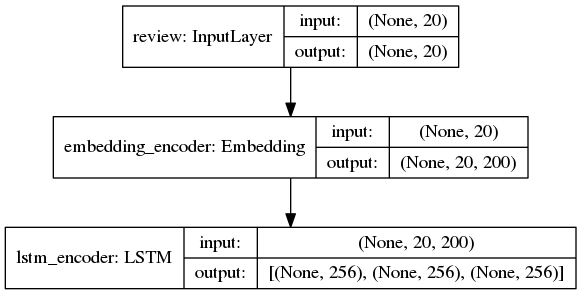

In [44]:
# Define inference model
encoder_inference_model = Model(review_input_layer, encoder_states)
plot_model(encoder_inference_model, to_file='inference_encoder.png', show_shapes=True)

Image(filename='inference_encoder.png') 

### 2.2 Decoder
- 3 inputs to the decoder are, previous time step hidden state, previous time step cell state and input at current timestep
- For first time step we have though vector as, hidden state and cell state as inputs from previous time step
- After that, decoder cell is called recursively

In [45]:
#Exactly same decoder model is used with different input and output adjustments

decoder_state_input_h = Input(shape=(LATENT_DIM,))  # These states are required for feeding back to our next timestep decoder
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Now we shall reuse our decoder
summary_for_decoder = Input(shape=(1,))
embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(embedding_summary_decoder, initial_state = decoder_states_inputs)
decoder_states_outputs = [decoder_states_c, decoder_states_h]
output_prob = decoder_dense_layer(decoder_inference_output)
decoder_inference_model = Model(
    [summary_for_decoder] + decoder_states_inputs,
    decoder_states_outputs + [output_prob])

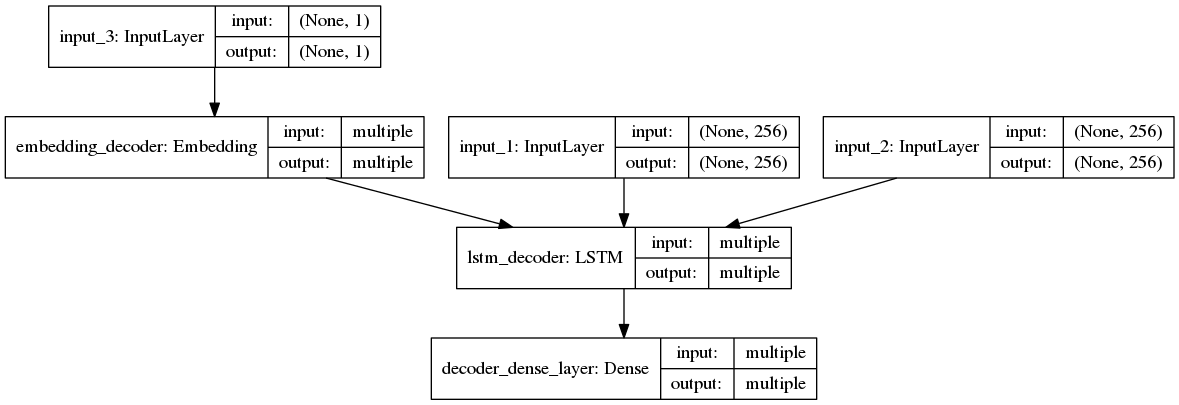

In [46]:
plot_model(decoder_inference_model, to_file='inference_decoder.png', show_shapes=True)

Image(filename='inference_decoder.png') 

In [47]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt


def decode_sequence(input_sequence):
    # Encode the input as state vectors. states_h and states_c for decoder init
    encoder_states_value = encoder_inference_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1, for decoder input  
    # Populate the first character of target sequence with the start character.
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = tokenize.word_index['SOS']
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = []
   
    while not stop_condition:
      
        h, c, output_tokens = decoder_inference_model.predict([target_sequence] + encoder_states_value,batch_size=1)
        # Sample a token
        
        sampled_word_index = np.argmax(output_tokens)#np.random.choice(np.arange(10003), p=output_tokens.flatten())
        sampled_word = indexToWordDict[sampled_word_index]
        decoded_sentence += [sampled_word]
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == 'EOS' or
           len(decoded_sentence) > MAX_SEQUENCE_SUMMARY_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1).
            target_sequence[0, 0] = sampled_word_index
        # Update states
        encoder_states_value = [h, c]
    return ' '.join(decoded_sentence)

## Try it !

In [48]:
def summarize(input_seq):
    input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text(input_seq)]),MAX_SEQUENCE_REVIEW_LENGTH)
    return decode_sequence(input_seq)

In [49]:
summarize("The book was very nice, will read it again")

'SOS seventy counting book book book EOS'

In [50]:
summarize("very very bad book, didn't like it much")

'SOS seventy counting book book book book EOS'

In [51]:
# Try if it's overfitting
for index,row in kindle_reviews.head().iterrows():
    print("Input review : " , row.review)
    print("Expected review : ", row.summary)
    print("Predicted output : ", summarize(row.review))
    print("\n")

Input review :  like period pieces clothing lingo enjoy mystery author guessing 2 3 way through
Expected review :  period mystery
Predicted output :  SOS seventy seventy counting book book book book book EOS


Input review :  did not book cover double ll did author came through good book characters plot interesting
Expected review :  irish luck
Predicted output :  SOS seventy seventy counting book book book book book book


Input review :  like louis l amour s books no exception want 6 words words words words words words words
Expected review :  good l l read
Predicted output :  SOS seventy seventy counting book book book book book book


Input review :  look forward getting books cannot recall exactly book about good book real good reading
Expected review :  also exciting descriptive
Predicted output :  SOS seventy seventy counting book book book book book EOS


Input review :  love newspaper kindle really enjoy insightful opinion pieces quick read days headlines apply non financial t

In the next notebook 
- I have implemented a pipeline for pre-processing text data
- try bidirectional CuDNNLSTM 
- attention mechanism
- beam search
- seq2seq-vis by IBM